In [2]:
"""
Импортируем необходимые библиотеки для создания генеративно-состязательной сети
Код разработан в основном с использованием библиотеки PyTorch
"""
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
from model import discriminator, generator
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset

In [3]:
"""
Определяем, доступны ли какие-либо графические процессоры
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda:0") # Let's make sure GPU is available!
print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1660 Ti


In [3]:
# !wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2023-01-12 19:38:53--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2023-01-12 19:38:54--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [83]:
"""
Hyperparameter settings
"""
epochs = 5
lr = 2e-4
batch_size = 64
loss = nn.BCELoss()

# Model
G = generator().to(device)
D = discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


"""
Image transformation and dataloader creation
Note that we are training generation and not classification, and hence
only the train_loader is loaded
"""
# Transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Load data
train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)

# takes the first 10% images of MNIST train set
subset_train = Subset(train_set, indices=range(len(train_set) // 20))
print("subset train shape", subset_train.dataset.data.shape)

train_loader = DataLoader(subset_train, batch_size=batch_size, shuffle=True)
print("train set shape", len(train_set.data))


"""
Network training procedure
Every step both the loss for disciminator and generator is updated
Discriminator aims to classify reals and fakes
Generator aims to generate images as realistic as possible
"""
for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

        # Training the discriminator
        # Real inputs are actual images of the MNIST dataset
        # Fake inputs are from the generator
        # Real inputs should be classified as 1 and fake as 0
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5 
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Training the generator
        # For generator, goal is to make the discriminator believe everything is 1
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5 
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        # мы замораживаем слои для дискриминатора и делаем backward только для генератора
        G_loss.backward()
        G_optimizer.step()

        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')


/home/arseniy/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


subset train shape torch.Size([60000, 28, 28])
train set shape 60000
Epoch 0 Iteration 47: discriminator_loss 0.613 generator_loss 0.850
Epoch 1 Iteration 47: discriminator_loss 0.536 generator_loss 1.117
Epoch 2 Iteration 47: discriminator_loss 0.693 generator_loss 0.790
Epoch 3 Iteration 47: discriminator_loss 0.676 generator_loss 0.781
Epoch 4 Iteration 47: discriminator_loss 0.640 generator_loss 0.779


NVIDIA GeForce GTX 1660 Ti


tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

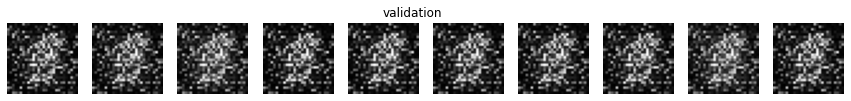

In [85]:
# for idx, (imgs, labels) in enumerate(train_loader):
#     print(labels[idx])
#     if idx ==10: 
#         break
noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5 
# print("shape", noise.shape)
noise = noise.to(device)
fake_inputs = G(noise)
# print("fake inputs shape ", fake_inputs.shape)
fake_outputs = D(fake_inputs)
fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

number = 10
fig = plt.figure(figsize=(15,1.5))
fig.suptitle("validation")
for i in range(number):
        plt.subplot(1,number, i+1)
        plt.axis('off')
        plt.imshow(fake_inputs[i].permute(1, 2, 0).detach().cpu(), cmap='gray')

# outputs = torch.cat((real_outputs, fake_outputs), 0)
# targets = torch.cat((real_label, fake_label), 0)
# print(targets[0].detach().cpu())

# labels = fake_label.detach().cpu()
# print(labels[:10])
x, _ = next(iter(train_loader))
print(x[0])

In [49]:
"""
Импортируем необходимые библиотеки для создания генеративно-состязательной сети
Код разработан в основном с использованием библиотеки PyTorch
"""
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
from model import discriminator, generator
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from torch.optim.lr_scheduler import StepLR


"""
Определяем, доступны ли какие-либо графические процессоры
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Генерация двумерных срезов керна

In [50]:
def read_raw(ct_path, volume_size=30, dtype=np.uint8):
    
        pixels = np.fromfile(ct_path, dtype=dtype)
        stack_size = int(pixels.shape[0] / volume_size ** 2)
        raw_data_cube = pixels.reshape((stack_size, volume_size, volume_size))

        return raw_data_cube

def generateBatches(batch_size, num_train):
        shuffled_indices = np.arange(num_train)
        np.random.shuffle(shuffled_indices)
        sections = np.arange(batch_size, num_train, batch_size)

        # print("sections shape is\n",sections)
        batches_indices = np.array_split(shuffled_indices, sections)
        return batches_indices



# images1 = read_raw("/home/arseniy/Desktop/DataImages/GANTESTING/5479_28_28_500.raw", volume_size=28)
images = read_raw("/home/arseniy/Desktop/DataImages/GANTESTING/5548_28_28_500.raw", volume_size=28)
images = images[212:257]
# images3 = read_raw("/home/arseniy/Desktop/DataImages/GANTESTING/9005_28_28_500.raw", volume_size=28)
# images4 = read_raw("/home/arseniy/Desktop/DataImages/GANTESTING/15581_28_28_500.raw", volume_size=28)
# images5 = read_raw("/home/arseniy/Desktop/DataImages/GANTESTING/15588_28_28_500.raw", volume_size=28)
# images6 = read_raw("/home/arseniy/Desktop/DataImages/GANTESTING/15604_28_28_500.raw", volume_size=28)
# images = np.concatenate((images1, images2, images3, images4, images5, images6), axis=0)

print("shape ", images.shape)

batch_size = 32
num_train = images.shape[0]

batches_indices = generateBatches(batch_size, num_train)

shape  (45, 28, 28)


In [63]:
"""
Hyperparameter settings
"""
epochs = 5000
lr = 1e-4
batch_size = 5
noize_size = 128
torch.manual_seed(0)
np.random.seed(0)

loss = nn.BCELoss()

# Model
G = generator().to(device)
D = discriminator().to(device)


G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)
g_scheduler = StepLR(G_optimizer, step_size=1, gamma=0.999)
d_scheduler = StepLR(D_optimizer, step_size=1, gamma=0.999)

images = images.astype(np.float32)
imgs = torch.tensor(images)

print("imgs shape ",imgs.shape)
g_loss_history = []
d_loss_history = []


"""
Network training procedure
Every step both the loss for disciminator and generator is updated
Discriminator aims to classify reals and fakes
Generator aims to generate images as realistic as possible
"""
for epoch in range(epochs):
    batches_indices = generateBatches(batch_size, len(imgs))
    idx = 0
    for batch_indices in batches_indices:
        idx += 1
        batch_imgs = imgs[batch_indices]

        # Training the discriminator
        # Real inputs are actual images of the MNIST dataset
        # Fake inputs are from the generator
        # Real inputs should be classified as 1 and fake as 0
        real_inputs = batch_imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128)) 
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Training the generator
        # For generator, goal is to make the discriminator believe everything is 1
        noise = (torch.rand(real_inputs.shape[0], 128))
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        # мы замораживаем слои для дискриминатора и делаем backward только для генератора
        G_loss.backward()
        G_optimizer.step()


        g_scheduler.step()
        d_scheduler.step()
        # if idx % 100 == 0 or idx == len(batch_indices)-1:
            # d_loss_history.append(D_loss.item())
            # g_loss_history.append(G_loss.item())
            # print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

    # if (epoch+1) % 10 == 0:
    #     torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
    #     print('Model saved.')


imgs shape  torch.Size([45, 28, 28])


shape torch.Size([5, 128])


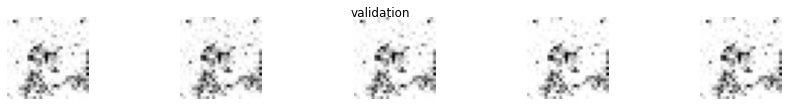

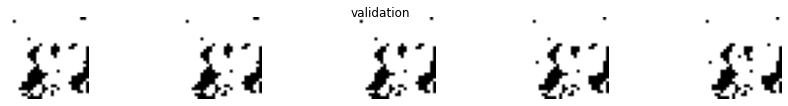

In [81]:
# plt.plot(g_loss_history)
# plt.show()
noise = (torch.rand(real_inputs.shape[0], noize_size))
print("shape", noise.shape)
noise = noise.to(device)
fake_inputs = G(noise)
# fake_inputs[fake_inputs<0]=0
# fake_inputs[fake_inputs>1]=1
# print("fake inputs ", fake_inputs)


number = 5
fig = plt.figure(figsize=(15,1.5))
fig.suptitle("validation")
for i in range(number):
        plt.subplot(1,number, i+1)
        plt.axis('off')
        plt.imshow(fake_inputs[i].permute(1, 2, 0).detach().cpu(), cmap='gray')
        # plt.imshow(images[i], cmap='gray')


fig = plt.figure(figsize=(15,1.5))
fig.suptitle("validation")
for i in range(number):
        plt.subplot(1,number, i+1)
        plt.axis('off')
        # plt.imshow(fake_inputs[i].permute(1, 2, 0).detach().cpu(), cmap='gray')
        plt.imshow(images[i], cmap='gray')



# plt.imshow(images[i].permute(1, 2, 0).detach().cpu())

In [40]:
"""
Импортируем необходимые библиотеки для создания генеративно-состязательной сети
Код разработан в основном с использованием библиотеки PyTorch
"""
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
from Mymodel import discriminator, generator
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from random import randint
from torch.optim.lr_scheduler import StepLR

"""
Hyperparameter settings
"""
epochs = 60
lr = 2e-3
noize_size = 300
torch.manual_seed(0)
np.random.seed(0)
batch_size = 5
loss = nn.BCELoss()

images = read_raw("/home/arseniy/Desktop/DataImages/GANTESTING/5548_30_30_500.raw", volume_size=30)
images = images[212:257]

# Model
G = generator().to(device)
D = discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, weight_decay=1e-6)
D_optimizer = optim.Adam(D.parameters(), lr=lr, weight_decay=1e-6)
g_scheduler = StepLR(G_optimizer, step_size=1, gamma=0.999)
d_scheduler = StepLR(D_optimizer, step_size=1, gamma=0.999)

images = images.astype(np.float32)
imgs = torch.tensor(images)
print("imgs shape ",len(imgs))
g_loss_history = []
d_loss_history = []

"""
Network training procedure
Every step both the loss for disciminator and generator is updated
Discriminator aims to classify reals and fakes
Generator aims to generate images as realistic as possible
"""
for epoch in range(epochs):
    # for idx, (imgs, _) in enumerate(train_loader):
    batches_indices = generateBatches(batch_size, len(imgs))
    idx = 0
    for batch_indices in batches_indices:
        idx += 1
        batch_imgs = imgs[batch_indices]

        # Training the discriminator
        # Real inputs are actual images of the MNIST dataset
        # Fake inputs are from the generator
        # Real inputs should be classified as 1 and fake as 0
        real_inputs = batch_imgs.to(device)
        # print("real_inputs shape ", real_inputs.shape)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], noize_size))
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Training the generator
        # For generator, goal is to make the discriminator believe everything is 1
        noise = (torch.rand(real_inputs.shape[0], noize_size)) 
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        # мы замораживаем слои для дискриминатора и делаем backward только для генератора
        G_loss.backward()
        G_optimizer.step()

    g_scheduler.step()
    d_scheduler.step()
    if epoch % 5 == 0:
            d_loss_history.append(D_loss.item())
            g_loss_history.append(G_loss.item())
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, d_loss_history[-1], g_loss_history[-1]))
    # if (epoch+1) % 10 == 0:
            # torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
            # print('Model saved.')


imgs shape  45
Epoch 0 Iteration 9: discriminator_loss 0.003 generator_loss 17.935
Epoch 5 Iteration 9: discriminator_loss 0.000 generator_loss 67.755
Epoch 10 Iteration 9: discriminator_loss 0.000 generator_loss 67.442
Epoch 15 Iteration 9: discriminator_loss 0.000 generator_loss 66.792
Epoch 20 Iteration 9: discriminator_loss 0.000 generator_loss 66.265
Epoch 25 Iteration 9: discriminator_loss 0.000 generator_loss 65.782
Epoch 30 Iteration 9: discriminator_loss 0.000 generator_loss 65.323
Epoch 35 Iteration 9: discriminator_loss 0.000 generator_loss 64.877
Epoch 40 Iteration 9: discriminator_loss 0.000 generator_loss 64.436
Epoch 45 Iteration 9: discriminator_loss 0.000 generator_loss 63.995
Epoch 50 Iteration 9: discriminator_loss 0.000 generator_loss 63.556
Epoch 55 Iteration 9: discriminator_loss 0.000 generator_loss 63.119


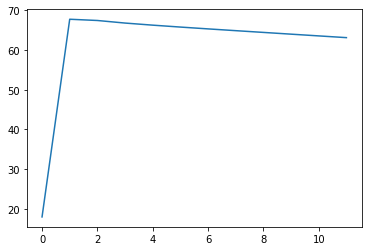

shape torch.Size([5, 300])
fake inputs shape  torch.Size([5, 1, 30, 30])


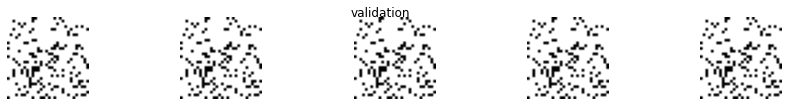

In [41]:
plt.plot(g_loss_history)
plt.show()
noise = (torch.rand(real_inputs.shape[0], noize_size))
print("shape", noise.shape)
noise = noise.to(device)
fake_inputs = G(noise)
print("fake inputs shape ", fake_inputs.shape)


number = 5
fig = plt.figure(figsize=(15,1.5))
fig.suptitle("validation")
for i in range(number):
        plt.subplot(1,number, i+1)
        plt.axis('off')
        plt.imshow(fake_inputs[i].permute(1, 2, 0).detach().cpu(), cmap='gray')
        # plt.imshow(images[i], cmap='gray')



# plt.imshow(images[i].permute(1, 2, 0).detach().cpu())

In [7]:
# from random import randint
# print(np.random.randint(0,2, size=(real_inputs.shape[0], 300)))
# noise_arr = np.random.randint(0,2, size=(real_inputs.shape[0], 300))
# noise = torch.tensor(noise_arr)
# print((torch.rand(real_inputs.shape[0], 3)))
# print(torch.randn(4))

# shuffled_indices = np.arange(199)
# np.random.shuffle(shuffled_indices)
# sections = np.arange(32, 250, 32)
# print("shaffled indices \n", shuffled_indices)
# print("sections is\n",sections)
# batches_indices = np.array_split(shuffled_indices, sections)
# print(batches_indices)


shaffled indices 
 [102 124 187 123  29 176 106  28 169 175  68 177   5  24  79 154 165 130
  58 166 120   9 134 178 191  30 121  52 151 112 159 184  83  95  35  65
  22  82 110  84  16  51  71 153 144 160 126  13  80 140  25 150 115  17
 164 117  47 128  72 193 122  64 167 132   6  38  41 168  31 149  27 172
 181  44  94  97  92 157  11  98  89  36 197   0 118 111 137 161   1  50
  86 148  61 156  39  69  91 143 127 113  67  88  48  26 194 173  23  10
  14 125  37  77 133  60  19  43 158 192   2 188  96  78 135  55  45  54
 104 182 171 145  40 170   4 101 129  75 108 163  66 152 139 179  21  59
  42  70 183  76 186 103  12 146  56  93  46 114 180 147 155  20 131 136
   3  18   7 189  63  62 196  34 107   8 138  81 142 198  87  49 116 105
 141 185 109  32 190  15  53  33  90 174  57 195  85 100 162  74 119  73
  99]
sections is
 [ 32  64  96 128 160 192 224]
[array([102, 124, 187, 123,  29, 176, 106,  28, 169, 175,  68, 177,   5,
        24,  79, 154, 165, 130,  58, 166, 120,   9, 134,